In [17]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

from lightgbm import LGBMRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import t
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.metrics import mean_absolute_error

In [18]:
df = pd.read_csv('./data/bike_sharing_demand_train.csv')

In [19]:
df


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129


In [20]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [32]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
season,10718.0,2.530230,1.108708,1.00,2.0000,3.000,4.0000,4.0000
holiday,10718.0,0.029017,0.167861,0.00,0.0000,0.000,0.0000,1.0000
workingday,10718.0,0.680911,0.466145,0.00,0.0000,1.000,1.0000,1.0000
weather,10718.0,1.418455,0.634329,1.00,1.0000,1.000,2.0000,4.0000
temp,10718.0,20.390366,7.733579,0.82,13.9400,20.500,26.2400,41.0000
atemp,10718.0,23.826539,8.412334,0.76,16.6650,24.240,31.0600,45.4550
humidity,10718.0,61.959134,19.266091,0.00,47.0000,62.000,78.0000,100.0000
windspeed,10718.0,12.813319,8.176840,0.00,7.0015,12.998,16.9979,56.9969
count,10718.0,193.692013,181.648401,1.00,44.0000,148.000,286.0000,977.0000
hour,10718.0,11.542359,6.915466,0.00,6.0000,12.000,18.0000,23.0000


In [22]:
def decompose_bike_sharing_demand(df, share_type='count', samples=250, period=24):
    if samples == 'all':
        #decomposing all time series timestamps
        res = seasonal_decompose(df[share_type].values, period=period)
    else:
        #decomposing a sample of the time series
        res = seasonal_decompose(df[share_type].values[-samples:], period=period)

    observed = res.observed
    trend = res.trend
    seasonal = res.seasonal
    residual = res.resid

    #plot the complete time series
    fig, axs = plt.subplots(4, figsize=(16,8))
    axs[0].set_title('OBSERVED', fontsize=16)
    axs[0].plot(observed)
    axs[0].grid()

    #plot the trend of the time series
    axs[1].set_title('TREND', fontsize=16)
    axs[1].plot(trend)
    axs[1].grid()

    #plot the seasonality of the time series. Period=24 daily seasonality | Period=24*7 weekly seasonality.
    axs[2].set_title('SEASONALITY', fontsize=16)
    axs[2].plot(seasonal)
    axs[2].grid()

    #plot the noise of the time series
    axs[3].set_title('NOISE', fontsize=16)
    axs[3].plot(residual)
    axs[3].scatter(y=residual, x=range(len(residual)), alpha=0.5)
    axs[3].grid()

    plt.show()

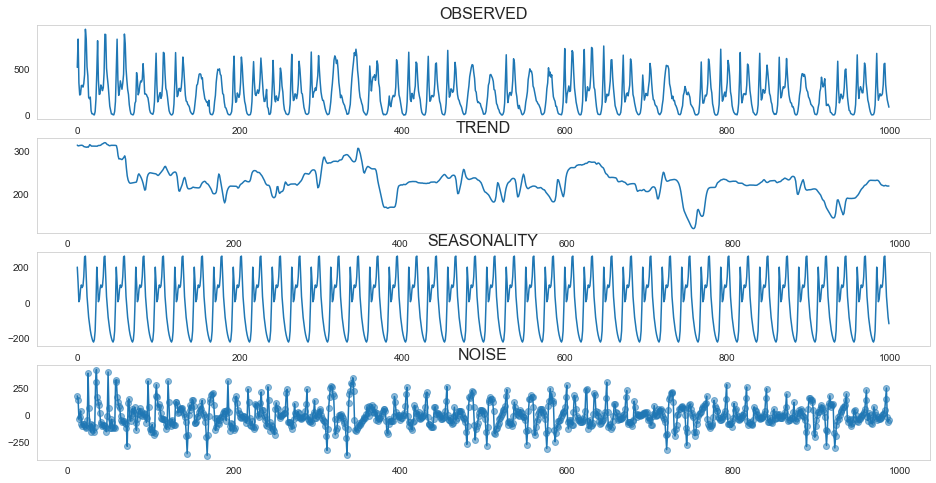

In [23]:
decompose_bike_sharing_demand(df, samples=1000, period=24)

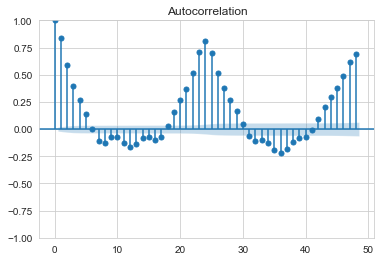

In [24]:
# autocorrelation graph
plot_acf(df['count'].values, lags=48)
plt.show()

In [25]:
# Microsoft's Light Gradient Boosting Machine

df

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129


In [26]:
#convert datetime from object to datetime type
df['datetime'] = pd.to_datetime(df['datetime'])
#set datetime as index
df = df.set_index(df.datetime)

#drop datetime column
df.drop('datetime', axis=1, inplace=True)

#create hour, day and month variables from datetime index
df['hour'] = df.index.hour
df['day'] = df.index.day
df['month'] = df.index.month

#drop casual and registered columns
df.drop(['casual', 'registered'], axis=1, inplace=True)


In [27]:
df

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,hour,day,month
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,16,0,1,1
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,40,1,1,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,32,2,1,1
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,13,3,1,1
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,1,4,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,336,19,19,12
2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,241,20,19,12
2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,168,21,19,12


In [28]:
# with one week lag
def train_time_series_with_folds(df, horizon=24*7):
    X = df.drop('count', axis=1)
    y = df['count']

    #take last week of the dataset for validation
    X_train, X_test = X.iloc[:-horizon,:], X.iloc[-horizon:,:]
    y_train, y_test = y.iloc[:-horizon], y.iloc[-horizon:]

    #create, train and do inference of the model
    model = LGBMRegressor(random_state=42)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    #calculate MAE
    mae = np.round(mean_absolute_error(y_test, predictions), 3)

    #plot reality vs prediction for the last week of the dataset
    fig = plt.figure(figsize=(16,6))
    plt.title(f'Real vs Prediction - MAE {mae}', fontsize=20)
    plt.plot(y_test, color='red')
    plt.plot(pd.Series(predictions, index=y_test.index), color='green')
    plt.xlabel('Hour', fontsize=16)
    plt.ylabel('Number of Shared Bikes', fontsize=16)
    plt.legend(labels=['Real', 'Prediction'], fontsize=16)
    plt.grid()
    plt.show()

    #create a dataframe with the variable importances of the model
    df_importances = pd.DataFrame({
        'feature': model.feature_name_,
        'importance': model.feature_importances_
    }).sort_values(by='importance', ascending=False)

    #plot variable importances of the model
    plt.title('Variable Importances', fontsize=16)
    sns.barplot(x=df_importances.importance, y=df_importances.feature, orient='h')
    plt.show()


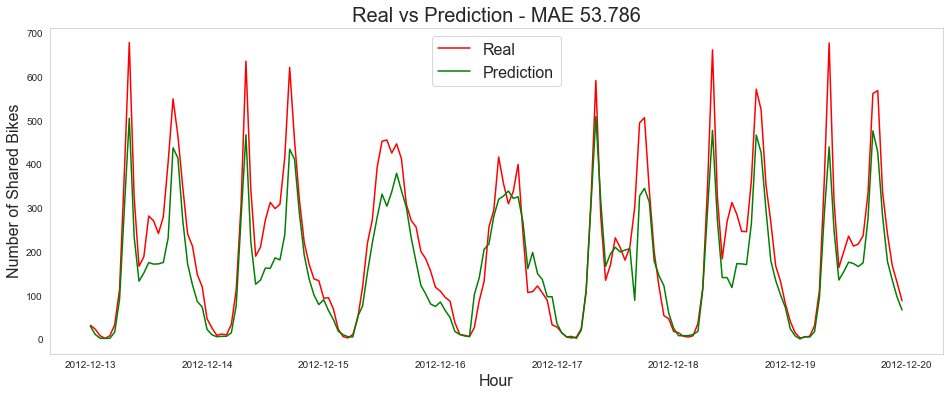

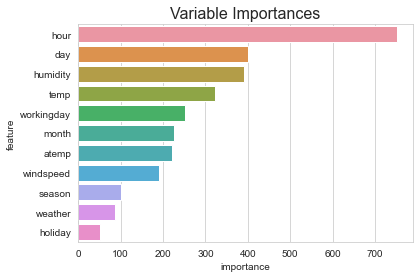

In [29]:
train_time_series_with_folds(df)

In [30]:
# Train model with Lags

#create 1 week lag variable by shifting the target value for 1 week
df['count_prev_week_same_hour'] = df['count'].shift(24*7)

#drop NaNs after feature engineering
df.dropna(how='any', axis=0, inplace=True)

In [33]:
df

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,hour,day,month,count_prev_week_same_hour
datetime,,,,,,,,,,,,,
2011-01-08 07:00:00,1,0,0,2,6.56,9.090,74,7.0015,9,7,8,1,16.0
2011-01-08 08:00:00,1,0,0,3,6.56,9.090,93,7.0015,15,8,8,1,40.0
2011-01-08 09:00:00,1,0,0,3,6.56,9.090,93,7.0015,20,9,8,1,32.0
2011-01-08 10:00:00,1,0,0,2,7.38,9.850,80,11.0014,61,10,8,1,13.0
2011-01-08 11:00:00,1,0,0,2,8.20,9.090,69,26.0027,62,11,8,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,336,19,19,12,402.0
2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,241,20,19,12,268.0
2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,168,21,19,12,202.0


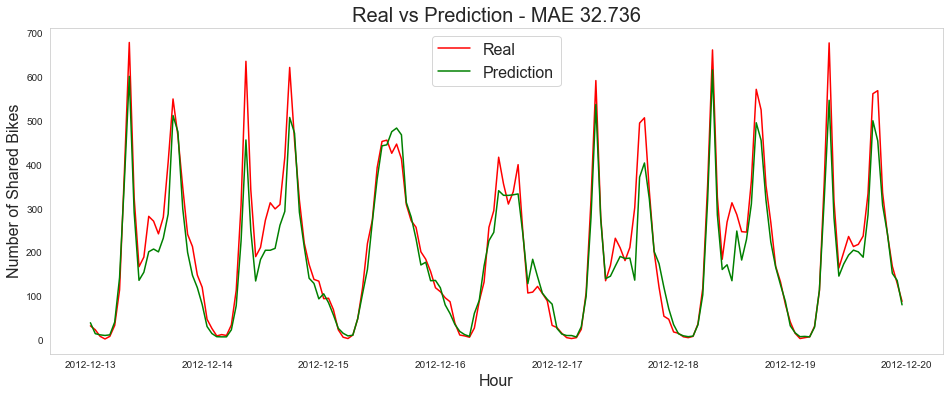

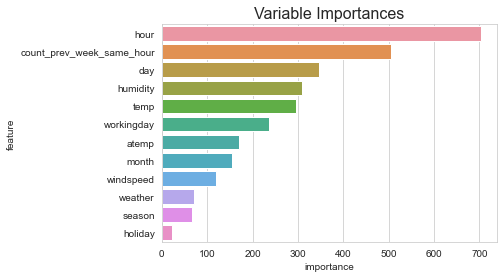

In [35]:
train_time_series_with_folds(df)
